In [ ]:
# Install wandb for saving training logs
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e02469d51262e0ce6c8ac494f25b244927393dc14b7e6df0e431f8870812ea7c
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
import time
import math
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### VGG model

##### with batch normalization

In [ ]:
class VGG19_with_bn(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19_with_bn, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv15 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
  
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        x = self.relu(self.bn1(self.conv1(input)))
        x = self.relu(self.bn1(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.relu(self.bn2(self.conv4(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn3(self.conv5(x)))
        x = self.relu(self.bn3(self.conv6(x)))
        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.bn3(self.conv8(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn4(self.conv9(x)))
        x = self.relu(self.bn4(self.conv10(x)))
        x = self.relu(self.bn4(self.conv11(x)))
        x = self.relu(self.bn4(self.conv12(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn4(self.conv13(x)))
        x = self.relu(self.bn4(self.conv14(x)))
        x = self.relu(self.bn4(self.conv15(x)))
        x = self.relu(self.bn4(self.conv16(x)))
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        x = F.log_softmax(x, dim=1)
        return x


### Set hyperparameters and train model

In [ ]:
# Initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training parameters
epochs = 30
batch_size = 256
learning_rate = 0.01
momentum = 0.9
weight_decay = 5*10e-4
batch_norm = True

# Construct the dataset and data loader
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.25, 0.24, 0.26)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49, 0.48, 0.45), (0.25, 0.24, 0.26)),
    transforms.Resize((224, 224)),
])

train_data = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Declare the network
model = VGG19_with_bn(num_classes=10).to(device)

# Loss function - Cross Entropy 
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer - Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=0.1)
# lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Initialize wandb
run = wandb.init(
    # set the wandb project where this run will be logged
    project="VGG-training-cifar10",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "VGG",
        "dataset": "CIFAR-10",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "momentum": "none",
        "weight_decay": weight_decay,
        "batch_norm": batch_norm,
        "written_model": "yes",
        "data-augmentation":"none",
        "others": "dropout 0.5 , lr scheduler 5, 0.1 gamma, weight init",
        "optimizer": "sgd",
        "log_softmax": "yes",
        "calculated data normalization": "yes"
    }
)

# Keep track of training and test loss
total_loss = [[], [], []]


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = []

    for (images, labels) in tqdm((dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        loss = loss_fn(pred, labels)
      
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

    scheduler.step()
    epoch_loss = np.mean(running_loss)
    print(f'loss: {epoch_loss:.3f}')
    return epoch_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_5 = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
            # Calculate top-5 accuracy
            _, pred_5 = pred.topk(5)

            for i in range(len(labels)):
                if labels[i] in pred_5[i]:
                    correct_5 += 1


    test_loss /= num_batches
    correct /= size
    correct_5/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Top-5 Accuracy: {(100*correct_5):>0.1f}%, \n Loss: {test_loss:>8f} \n")
    
    return test_loss, correct*100, correct_5*100

In [ ]:
print("Starting Training Loop...")
start_time = time.time()

for t in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")

    epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, top1_accuracy, top5_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    total_loss[0].append(t+1)
    total_loss[1].append(epoch_loss)
    total_loss[2].append(test_loss)
    
    wandb.log({ "training_loss": epoch_loss, "test_loss": test_loss, "acc": top1_accuracy, "top5_accuracy": top5_accuracy })

    print("current lr", scheduler.get_last_lr())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (t + 1, epochs, per_epoch_ptime))


print("Done!")
end_time = time.time()
total_ptime = end_time - start_time
print("Total time %.2f" % (total_ptime))

Starting Training Loop...
Epoch 1
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 2.753
Test Error: 
 Accuracy: 17.8%, Top-5 Accuracy: 70.3%, 
 Loss: 2.230572 

current lr [0.01]
Epoch 1 of 30 with 192.00 s
Epoch 2
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 1.908
Test Error: 
 Accuracy: 35.1%, Top-5 Accuracy: 86.8%, 
 Loss: 1.750786 

current lr [0.01]
Epoch 2 of 30 with 191.30 s
Epoch 3
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 1.617
Test Error: 
 Accuracy: 44.5%, Top-5 Accuracy: 91.6%, 
 Loss: 1.511064 

current lr [0.01]
Epoch 3 of 30 with 191.15 s
Epoch 4
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 1.434
Test Error: 
 Accuracy: 50.8%, Top-5 Accuracy: 93.6%, 
 Loss: 1.344176 

current lr [0.01]
Epoch 4 of 30 with 191.28 s
Epoch 5
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 1.257
Test Error: 
 Accuracy: 57.0%, Top-5 Accuracy: 95.0%, 
 Loss: 1.185415 

current lr [0.01]
Epoch 5 of 30 with 191.50 s
Epoch 6
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 1.071
Test Error: 
 Accuracy: 64.8%, Top-5 Accuracy: 96.8%, 
 Loss: 0.996965 

current lr [0.01]
Epoch 6 of 30 with 191.26 s
Epoch 7
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.905
Test Error: 
 Accuracy: 68.5%, Top-5 Accuracy: 97.5%, 
 Loss: 0.892371 

current lr [0.01]
Epoch 7 of 30 with 191.51 s
Epoch 8
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.766
Test Error: 
 Accuracy: 74.1%, Top-5 Accuracy: 98.4%, 
 Loss: 0.748406 

current lr [0.01]
Epoch 8 of 30 with 191.55 s
Epoch 9
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.669
Test Error: 
 Accuracy: 77.7%, Top-5 Accuracy: 98.5%, 
 Loss: 0.665572 

current lr [0.01]
Epoch 9 of 30 with 191.57 s
Epoch 10
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.585
Test Error: 
 Accuracy: 78.5%, Top-5 Accuracy: 98.7%, 
 Loss: 0.623914 

current lr [0.01]
Epoch 10 of 30 with 191.10 s
Epoch 11
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.526
Test Error: 
 Accuracy: 81.3%, Top-5 Accuracy: 99.0%, 
 Loss: 0.552945 

current lr [0.01]
Epoch 11 of 30 with 191.53 s
Epoch 12
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.470
Test Error: 
 Accuracy: 81.8%, Top-5 Accuracy: 99.1%, 
 Loss: 0.530915 

current lr [0.01]
Epoch 12 of 30 with 191.53 s
Epoch 13
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.427
Test Error: 
 Accuracy: 83.5%, Top-5 Accuracy: 99.2%, 
 Loss: 0.510423 

current lr [0.01]
Epoch 13 of 30 with 191.24 s
Epoch 14
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.392
Test Error: 
 Accuracy: 84.3%, Top-5 Accuracy: 99.3%, 
 Loss: 0.468166 

current lr [0.01]
Epoch 14 of 30 with 191.65 s
Epoch 15
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.360
Test Error: 
 Accuracy: 85.2%, Top-5 Accuracy: 99.4%, 
 Loss: 0.452650 

current lr [0.001]
Epoch 15 of 30 with 191.18 s
Epoch 16
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.225
Test Error: 
 Accuracy: 89.1%, Top-5 Accuracy: 99.6%, 
 Loss: 0.329808 

current lr [0.001]
Epoch 16 of 30 with 191.44 s
Epoch 17
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.180
Test Error: 
 Accuracy: 89.3%, Top-5 Accuracy: 99.7%, 
 Loss: 0.321036 

current lr [0.001]
Epoch 17 of 30 with 191.44 s
Epoch 18
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.162
Test Error: 
 Accuracy: 89.6%, Top-5 Accuracy: 99.7%, 
 Loss: 0.311691 

current lr [0.001]
Epoch 18 of 30 with 191.14 s
Epoch 19
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.145
Test Error: 
 Accuracy: 89.6%, Top-5 Accuracy: 99.7%, 
 Loss: 0.308476 

current lr [0.001]
Epoch 19 of 30 with 191.30 s
Epoch 20
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.128
Test Error: 
 Accuracy: 89.9%, Top-5 Accuracy: 99.7%, 
 Loss: 0.309204 

current lr [0.001]
Epoch 20 of 30 with 191.38 s
Epoch 21
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.116
Test Error: 
 Accuracy: 90.2%, Top-5 Accuracy: 99.7%, 
 Loss: 0.308606 

current lr [0.001]
Epoch 21 of 30 with 191.48 s
Epoch 22
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.106
Test Error: 
 Accuracy: 90.2%, Top-5 Accuracy: 99.7%, 
 Loss: 0.307665 

current lr [0.001]
Epoch 22 of 30 with 191.65 s
Epoch 23
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.093
Test Error: 
 Accuracy: 90.2%, Top-5 Accuracy: 99.7%, 
 Loss: 0.302191 

current lr [0.001]
Epoch 23 of 30 with 191.39 s
Epoch 24
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.083
Test Error: 
 Accuracy: 90.0%, Top-5 Accuracy: 99.8%, 
 Loss: 0.305286 

current lr [0.001]
Epoch 24 of 30 with 191.87 s
Epoch 25
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.13it/s]


loss: 0.074
Test Error: 
 Accuracy: 90.1%, Top-5 Accuracy: 99.7%, 
 Loss: 0.313447 

current lr [0.0001]
Epoch 25 of 30 with 191.71 s
Epoch 26
-------------------------------


100%|██████████| 196/196 [02:53<00:00,  1.13it/s]


loss: 0.054
Test Error: 
 Accuracy: 91.0%, Top-5 Accuracy: 99.7%, 
 Loss: 0.289377 

current lr [0.0001]
Epoch 26 of 30 with 191.47 s
Epoch 27
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.051
Test Error: 
 Accuracy: 90.6%, Top-5 Accuracy: 99.7%, 
 Loss: 0.293435 

current lr [0.0001]
Epoch 27 of 30 with 191.82 s
Epoch 28
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.048
Test Error: 
 Accuracy: 90.9%, Top-5 Accuracy: 99.7%, 
 Loss: 0.294809 

current lr [0.0001]
Epoch 28 of 30 with 191.82 s
Epoch 29
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.048
Test Error: 
 Accuracy: 90.8%, Top-5 Accuracy: 99.8%, 
 Loss: 0.287515 

current lr [0.0001]
Epoch 29 of 30 with 192.10 s
Epoch 30
-------------------------------


100%|██████████| 196/196 [02:54<00:00,  1.12it/s]


loss: 0.045
Test Error: 
 Accuracy: 91.1%, Top-5 Accuracy: 99.7%, 
 Loss: 0.291192 

current lr [0.0001]
Epoch 30 of 30 with 192.24 s
Done!
Total time 5745.60


In [ ]:
test_loop(test_dataloader, model, loss_fn)

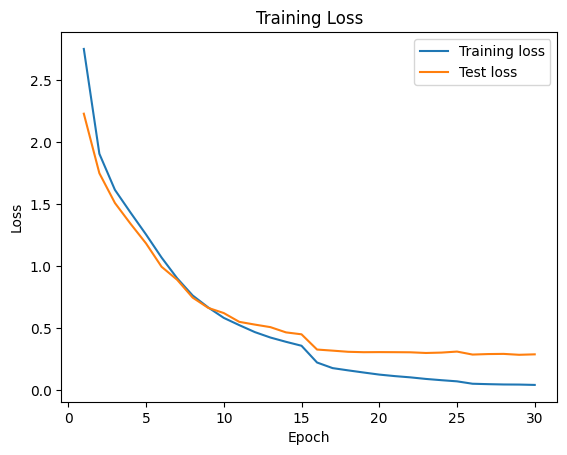

In [ ]:
plt.plot(total_loss[0], total_loss[1], label = "Training loss")
plt.plot(total_loss[0], total_loss[2], label = "Test loss")

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Close wandb run
run.finish()

acc,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇███████████████
test_loss,█▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top5_accuracy,▁▅▆▇▇▇▇███████████████████████
training_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,91.14
test_loss,0.29119
top5_accuracy,99.73
training_loss,0.04473


In [ ]:
# Save model
torch.save(model, 'vgg_cifar10_model.pth')
torch.save(model.state_dict(), 'vgg_cifar10_model_weights.pth')